# Covid-19 Genome Analysis Repository

## GOAL: Download and analyze the coronovirus genome.
https://www.ncbi.nlm.nih.gov/genbank/sars-cov-2-seqs/

#### Inspiration:
https://blog.floydhub.com/exploring-dna-with-deep-learning/

## Connect to NCBI Database and get a list of genome ids based on a particular search

In [24]:
from Bio import Entrez
from Bio import SeqIO
import os
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [25]:
######################################
# Retrieve NCBI Data Online
######################################
Entrez.email = "daniel.delvin.diaz+ncbi@gmail.com"  # Always tell NCBI who you are
search_term = "SARS-CoV2[orgn] AND complete genome[title]"
handle = Entrez.esearch(db="nucleotide", term=search_term)
search_results = Entrez.read(handle)
genome_ids = search_results['IdList']

## Print out one of the results so we can inspect it.

In [26]:
######################################
# Check genome data
######################################

print(f"Found {len(genome_ids)} genomes.")
# Ref Genome: NC_045512
for g in genome_ids:
    handle = Entrez.efetch(db="nucleotide", id=g, rettype="gb", retmode="text")
    text = handle.read()
    # print(text)
    break
    # Note page limit of 20, so there will only be 20 results here, which should be fine

Found 20 genomes.


## Download all the genomes from our search and store them as .gb files.

In [27]:
######################################
# Download Genomes
######################################

count = 0
for genome_id in genome_ids:
    # lets break after downloading 3 genomes
    if count == 3:
        break
    count += 1

    filename = f'{os.path.abspath(".")}/generated/genBankRecord_{genome_id}.gb'
    # Lets not download the genome if we already have it.
    if os.path.isfile(filename):
        print('Skipping:{}'.format(filename))
        continue

    record = Entrez.efetch(db="nucleotide", id=genome_id, rettype="gb", retmode="text")

    print('Writing:{}'.format(filename))
    with open(filename, 'w') as f:
        f.write(record.read())
    # Im noticing some really wonky file permissions with jupyter notebook and pycharm
    # going to force it to be this:
    # Dont forget this is python3 specific syntax
    os.chmod(filename, 0o666)



Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_1829138121.gb
Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_1829138108.gb
Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_1829138095.gb


## Download ref genome for sars-covid-2
## Which btw was made with an Illumina Genome Sequencer! :) Nice

In [28]:
######################################
# Download Ref Genome
######################################
Entrez.email = "daniel.delvin.diaz+ncbi@gmail.com"  # Always tell NCBI who you are
search_term = "NC_045512[locus] AND complete genome[title]"
handle = Entrez.esearch(db="nucleotide", term=search_term)
search_results = Entrez.read(handle)
ref_genome_id = search_results['IdList'][0]
record = Entrez.efetch(db="nucleotide", id=ref_genome_id, rettype="gb", retmode="text")
# print(record.read())
filename = f'{os.path.abspath(".")}/ref_genome/genBankRecord_ref.gb'
with open(filename, 'w') as f:
    content = record.read()
    # print(content)
    f.write(content)
print('File Written:{}'.format(filename))
# Note I have noticed a weird behavior with pycharm + jupyter notebook where you wont see the
# file locally unless you click out of pycharm then back in.

File Written:/Users/ddiaz/src/corona/ref_genome/genBankRecord_ref.gb


## Set up functions to transform the genome into its one-hot encoded form.

In [29]:
######################################
# Setup One Hot Encoding Function
######################################

# One hot encode a DNA sequence string
# non 'acgt' bases (n) are 0000
# returns a L x 4 numpy array

label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t','z']))

def string_to_array(my_string):
    my_string = my_string.lower()
    my_string = re.sub('[^acgt]', 'z', my_string)
    my_array = np.array(list(my_string))
    return my_array

def one_hot_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1)
    return onehot_encoded

test_sequence = 'AACGCGGTTNN'
test_sequence_hot = one_hot_encoder(string_to_array(test_sequence))
expected_sequence_hot =   [[1, 0, 0, 0],
                           [1, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 1, 0],
                           [0, 1, 0, 0],
                           [0, 0, 1, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1],
                           [0, 0, 0, 1],
                           [0, 0, 0, 0],
                           [0, 0, 0, 0]]

# Lets check this function is working as expected
assert np.array_equal(test_sequence_hot, expected_sequence_hot)

## Load Ref Genome

In [30]:
ref_genome_path = f"{os.path.abspath('.')}/ref_genome/genBankRecord_ref.gb"
ref_genome_seq = None
for seq_record in SeqIO.parse("./ref_genome/genBankRecord_ref.gb", "genbank"):
    print(f"SARS-CoV-2 Genome: {seq_record.seq}")
    ref_genome_seq = seq_record.seq

SARS-CoV-2 Genome: ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGC

In [31]:
# r = ref_genome_seq[0:5]
ref_seq_hot = one_hot_encoder(string_to_array(str(ref_genome_seq)))

# DEV Note: Because there are no unknown letters in the ref genome, the output hot encoding is only 3 positions instead of
# 4 like in the test above.
#print(r)
print(ref_seq_hot)


[[1 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]


#### Quick note:
Notice then above array is only 3 bits
```text
[1 0 0]
A 1 in the first position means A.
A 1 in the second position means C.
A 1 in the third position means G.
And all zeros means T
```

## Let's create a generic function that does the genome load and one hot encoding

In [32]:
def get_one_hot_genome_encoding(gb_file_path):
    """
    :arg gb_file_path: Load a GB file
    Get the genome from that file
    One hot encode that genome
    :returns A one hot encode genome
    """
    for seq_record in SeqIO.parse(gb_file_path, "genbank"):
        print(f"SARS-CoV-2 Genome: {seq_record.seq}")
        genome_seq = str(seq_record.seq)
        # Lets assume theres one genome per file
        seq_hot = one_hot_encoder(string_to_array(genome_seq))
        return seq_hot


## Lets get all the one hot encodings for the gb files we have

In [33]:
def get_one_hot_encodings_from_folder(folder_path=os.path.abspath('.')+"/generated/"):
    f = []
    print(f"Using folder {folder_path} for analysis")
    for (root, dirnames, filenames) in os.walk(folder_path):
        for filename in filenames:
            f.append(os.path.join(root,filename))
    print(f)
    result = []
    for genome_file in f:
        print(f"Getting One Hot Encoding from {genome_file}")
        r = get_one_hot_genome_encoding(genome_file)
        print(r)
        result.append(r)
    return result

one_hot_encoded_genomes = get_one_hot_encodings_from_folder()

print("Array of one hot encoded genomes")
print(one_hot_encoded_genomes)


Using folder /Users/ddiaz/src/corona/generated/ for analysis
['/Users/ddiaz/src/corona/generated/genBankRecord_1829138121.gb', '/Users/ddiaz/src/corona/generated/genBankRecord_1829138095.gb', '/Users/ddiaz/src/corona/generated/genBankRecord_1829138108.gb']
Getting One Hot Encoding from /Users/ddiaz/src/corona/generated/genBankRecord_1829138121.gb
SARS-CoV-2 Genome: AACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGC

## Next step is to try and generate the mutation diagram
- Each row will be an different seq

[[0, 0, 0]]
[0, 0, 0]
[0, 0, 1]
[[0, 0, 0], [0, 0, 0], [0, 0, 1]]


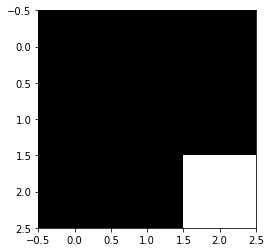

In [34]:
# ACG
g1_ref = [[1,0,0,0],[0,1,0,0],[0,0,1,0]]
# ACG
g2 = [[1,0,0,0],[0,1,0,0],[0,0,1,0]]
# ACT
# This one has a mutation in the 3rd letter
g3 = [[1,0,0,0],[0,1,0,0],[0,0,0,1]]

# Two options, we can either compare to the ref genome, or compare to an array that represents
# the most common letter in that position

# Lets start with the former, then move to the latter
# A final zero bit (black) will be ref genome
# A one (white) will be mutation from ref genome

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# X = np.random.random((100, 100)) # sample 2D array
# plt.imshow(X, cmap="gray")
# plt.show()

# this is our basline, all zeros
genome_chart = [[0]*len(g1_ref)]
print(genome_chart)

def compare(ref_genome, new_genome):
    i = 0
    result = []
    for i in range(len(ref_genome)):
        # check if arrays are equal, if not write a 1
        # sometimes arrays arent equal. for now, lets just assume thats a mutation
        if np.array_equal(ref_genome[i], new_genome[i]):
            result.append(0)
        else:
            result.append(1)
    return result

result1 = compare(g1_ref,g2)
print(result1)
result2 = compare(g1_ref,g3)
print(result2)
genome_chart.append(result1)
genome_chart.append(result2)
print(genome_chart)

plt.imshow(genome_chart, cmap="gray")
plt.show()

## Ok let's pause.
Above we created 3 sample genomes that were only 3 letters long. one was the ref genome.
Only one genome had a mutation in the last position.
So if we compare that to the chart, the top row is the ref genome, its all black becuase its the ref.
THe bottom row is the mutated genome, with the last column, last row being white as thats were the mutation is.


In [35]:
# Now lets do the same thing to the 3 genomes we have.
g1 = ref_seq_hot
gN = one_hot_encoded_genomes
genome_chart = [[0]*len(g1)]
for genome in gN:
    c = compare(g1,gN)
    genome_chart.append(c)

plt.imshow(genome_chart, cmap="gray")
plt.show()


IndexError: list index out of range

## Possible improvements
- im only comparing to the ref genome. it would probably be more interesting to derive the most common letter for that position, then label one wild, and one mutation.
- if genomes arent equal in len , we just assume mutation, there should be a better way to go about this.

Links:
http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc132
https://www.kaggle.com/thomasnelson/working-with-dna-sequence-data-for-ml
